In [141]:
import xml.etree.ElementTree as ET
import os
import numpy as np

seq_list = [] # list of sequences of pen vectors

maxdiff = 0

# Iterate through xml files
folders = os.listdir('original')
for folder in folders:
    files = os.listdir('original/' + folder)
    vecs = [] # used within loop to store all pen vectors within a given line
    for file in files:
        tree = ET.parse('original/' + folder + '/' + file + '/strokesz.xml')
        root = tree.getroot()

        # Save the x-y-EOS series as a numpy array, put it in list
        stroke_set = root.find('StrokeSet').findall('Stroke')
        # For getting displacement vector between strokes
        lastx = 0
        lasty = 0
        for stroke_num, stroke in enumerate(stroke_set):
            point_set = stroke.findall('Point')
            end = len(point_set) - 1
            for i, point in enumerate(point_set):
                x = float(point.get('x')) # pen offset in x direction
                y = float(point.get('y')) # pen offset in y direction
                    
                if i == 0 and stroke_num == 0:
                    lastx = x
                    lasty = y
                    continue
                    
                xdiff = x - lastx
                ydiff = y - lasty
                
                lastx = x
                lasty = y
                    
                eos = float(i == end)
                
                # If we got to a new line, start a new sequence. If we got a few strokes 
                if abs(xdiff) > 1000 or abs(ydiff) > 1000:
                    if len(vecs) > 1:
                        seq_list.append(np.array(vecs, dtype=np.float64))
                    vecs = []
                else:
                    vecs.append([xdiff, ydiff, eos])
                    if abs(xdiff) > maxdiff:
                        maxdiff = abs(xdiff)
                    if abs(ydiff) > maxdiff:
                        maxdiff = abs(ydiff)

    if len(vecs) > 1:
        seq_list.append(np.array(vecs, dtype=np.float64))
    
print('Done parsing')

Done parsing


In [143]:
# paper recommends normalizing stroke vectors
for i in range(len(seq_list)):
    for j in range(len(seq_list[i])):
        seq_list[i][j][0] /= maxdiff
        seq_list[i][j][1] /= maxdiff

In [144]:
import torch
import random

In [145]:
class GeneratorCell(torch.nn.Module):
    def __init__(self, hidden_size, mixture_size):
        super(GeneratorCell, self).__init__()

        self.gru = torch.nn.GRU(input_size=3, hidden_size=hidden_size, batch_first=True)
        self.hidden_size= hidden_size
        self.mixture_size = mixture_size

        # another layer cuz why not
        #self.linear0 = torch.nn.Linear(hidden_size, hidden_size)
        
        # for generating mixture weights
        self.linear1 = torch.nn.Linear(hidden_size, mixture_size)

        # for generating means
        self.linear2 = torch.nn.Linear(hidden_size, 2*mixture_size) 
        
        # for generating standard deviations
        self.linear3 = torch.nn.Linear(hidden_size, 2*mixture_size) 

        # for generating correlations
        self.linear4 = torch.nn.Linear(hidden_size, mixture_size) 

        # for generating EOS probability
        self.linear5 = torch.nn.Linear(hidden_size, 1)

    def forward(self, input_batch, seq_lengths, max_length):
        input_batch = torch.nn.utils.rnn.pack_padded_sequence(input_batch, seq_lengths, batch_first=True) # not zero-padded
        output, hidden = self.gru(input_batch)
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True) # zero-padded
        output.register_hook(lambda x: x.clamp(-10, 10)) # paper recommends clipping gradients

        mdn_input = torch.reshape(output, (-1, hidden_size))
        
        gmm_weights = torch.nn.functional.softmax(self.linear1(mdn_input), dim=1).view(-1, mixture_size, 1)
        
        gmm_means = self.linear2(mdn_input).view(-1, mixture_size, 2)
        gmm_stds = torch.exp(self.linear3(mdn_input)).view(-1, mixture_size, 2)
        gmm_corrs = torch.tanh(self.linear4(mdn_input)).view(-1, mixture_size, 1)
        eos_prob = torch.sigmoid(self.linear5(mdn_input))
        gaussian_params = torch.cat((gmm_weights, gmm_means, gmm_stds, gmm_corrs), 2)
        return gaussian_params, eos_prob
    
    # Given some (x, y, EOS), return the distribution parameters for the next (x, y, EOS) and the next hidden state
    def get_next(self, input, hidden):
        output, hidden = self.gru(input.view(1, 1, 3), hidden)
        
        # get rid of sequence index in output
        output = output.squeeze(1)

        gmm_weights = torch.nn.functional.softmax(self.linear1(output), dim=1).view(mixture_size, 1)
        gmm_means = self.linear2(output).view(mixture_size, 2)
        gmm_stds = torch.exp(self.linear3(output)).view(mixture_size, 2)
        gmm_corrs = torch.tanh(self.linear4(output)).view(mixture_size, 1)
        eos_prob = torch.sigmoid(self.linear5(output))
        gaussian_params = torch.cat((gmm_weights, gmm_means, gmm_stds, gmm_corrs), 1)
        return gaussian_params, eos_prob, hidden

In [207]:
# seq_lengths tells us where to select the output to account for zero padding
def log_likelihood_batched(input_batch, gaussian_param_batch, eos_batch, mixture_size, seq_lengths, max_length):
    input_batch = torch.reshape(input_batch, (-1, 3))
    
    ### Unpadding section is pretty confusing and should be cleaned up
    
    # selection mask containing ones at any indices where output isn't padded
    selection = torch.zeros(max_length*len(seq_lengths), dtype=torch.bool)
    for i, length in enumerate(seq_lengths):
        start_index = i*max_length
        selection[start_index:(start_index + length)] = torch.ones((length), dtype=torch.bool)
            
    input_batch = input_batch[selection]
    gaussian_param_batch = gaussian_param_batch[selection]
    eos_batch = eos_batch[selection]
    
    # Calculate bivariate Gaussian pdfs
    xdiff = input_batch[:, 0].unsqueeze(1).expand(-1, mixture_size) - gaussian_param_batch[:, :, 1] # x - mu_x
    ydiff = input_batch[:, 1].unsqueeze(1).expand(-1, mixture_size) - gaussian_param_batch[:, :, 2] # y - mu_y
    xstd = gaussian_param_batch[:, :, 3]
    ystd = gaussian_param_batch[:, :, 4]
    corr = gaussian_param_batch[:, :, 5]
    
    Z = (xdiff**2)/(xstd**2) + (ydiff**2)/(ystd**2) - 2*corr*xdiff*ydiff/(xstd*ystd)
    
    one_minus_corr_squared = 1 - corr**2
    
    prob = torch.exp(-Z/(2*one_minus_corr_squared))/(2*np.pi*xstd*ystd*torch.sqrt(one_minus_corr_squared))
    
    logprob = torch.log(torch.sum(prob*gaussian_param_batch[:, :, 0], 1)) # add gaussians, weighted by mixture weights
    eos = input_batch[:, 2]
    not_eos = 1 - eos
    logprob = logprob + eos*torch.log(eos_batch) + not_eos*torch.log(1 - eos_batch)
    logprob = torch.sum(logprob)/batch_size
    
    logprob.register_hook(lambda x: x.clamp(-100, 100)) # paper recommends clipping gradients
    
    return logprob

In [208]:
# Training loop
n_epochs = 10
batch_size = 15
n_iters = int(len(seq_list)/batch_size)
hidden_size = 100
mixture_size = 20

model = GeneratorCell(hidden_size, mixture_size).double()

In [209]:
model.load_state_dict(torch.load('trained_model.pth'))

<All keys matched successfully>

In [210]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

losses = np.zeros(n_epochs) # For plotting

In [212]:
try:
    for epoch in range(n_epochs):
        random.shuffle(seq_list)
        start_index = 0
        for iter in range(n_iters):
            if iter%100 == 0:
                print('Epoch: ' + str(epoch) + ' Iteration: ' + str(iter))
            
            batch = seq_list[start_index:(start_index + batch_size)]
            batch.sort(key = lambda x: len(x), reverse=True)
            seq_lengths = [len(seq) - 1 for seq in batch]

            max_length = max(seq_lengths)
            input_batch = torch.zeros((batch_size, max_length + 1, 3), dtype=torch.double) # zero-padded
            for i in range(batch_size):
                input_batch[i, 0:(seq_lengths[i] + 1), :] = torch.from_numpy(batch[i])
            input_batch = torch.autograd.Variable(input_batch)

            gaussian_param_batch, eos_batch = model.forward(input_batch, seq_lengths, max_length)

            optimizer.zero_grad()
            loss = -log_likelihood_batched(input_batch[:, 1:, :], gaussian_param_batch, eos_batch, mixture_size, seq_lengths, max_length)
            loss.backward()
            optimizer.step()

            losses[epoch] += loss.data
            start_index += batch_size
        print('Epoch Loss: ' + str(losses[epoch]))
except KeyboardInterrupt:# so you can stop training and resume later using ctrl-C
    torch.save(model.state_dict(), 'trained_model.pth')

Epoch: 0 Iteration: 0
Epoch: 0 Iteration: 100
Epoch: 0 Iteration: 200
Epoch: 0 Iteration: 300
Epoch: 0 Iteration: 400
Epoch: 0 Iteration: 500
Epoch: 0 Iteration: 600
Epoch: 0 Iteration: 700
Epoch: 0 Iteration: 800
Epoch Loss: -20705996369.55836
Epoch: 1 Iteration: 0
Epoch: 1 Iteration: 100
Epoch: 1 Iteration: 200
Epoch: 1 Iteration: 300
Epoch: 1 Iteration: 400
Epoch: 1 Iteration: 500
Epoch: 1 Iteration: 600
Epoch: 1 Iteration: 700
Epoch: 1 Iteration: 800
Epoch Loss: -22366126564.07274
Epoch: 2 Iteration: 0
Epoch: 2 Iteration: 100
Epoch: 2 Iteration: 200
Epoch: 2 Iteration: 300
Epoch: 2 Iteration: 400
Epoch: 2 Iteration: 500
Epoch: 2 Iteration: 600
Epoch: 2 Iteration: 700
Epoch: 2 Iteration: 800
Epoch Loss: -23783383966.917553
Epoch: 3 Iteration: 0
Epoch: 3 Iteration: 100
Epoch: 3 Iteration: 200
Epoch: 3 Iteration: 300
Epoch: 3 Iteration: 400
Epoch: 3 Iteration: 500
Epoch: 3 Iteration: 600
Epoch: 3 Iteration: 700
Epoch: 3 Iteration: 800
Epoch Loss: -24654967834.208435
Epoch: 4 Iteration

In [213]:
torch.save(model.state_dict(), 'trained_model.pth')

Next we have a plotter script to see what our model generates

In [214]:
import matplotlib.pyplot as plt

In [234]:
output_x = [0, 0.1] # list of x outputs. must supply 2 intially since the network takes a vector as an input
output_y = [0, 0.1] # list of y outputs
eos = 0 # does the previous output correspond to an eos
hidden = torch.zeros((1, 1, hidden_size), dtype=torch.double)
for i in range(700):
    input = torch.tensor([output_x[-1] - output_x[-2], output_y[-1] - output_y[-2], eos], dtype=torch.double)
    gaussian_params, eos, hidden = model.get_next(input, hidden)
    
    # choose which mixture to sample from
    k = np.random.choice(mixture_size, p=gaussian_params[:, 0].detach().numpy())
    
    #construct multivariate gaussian
    mu_x = gaussian_params[k, 1]
    mu_y = gaussian_params[k, 2]

    means = torch.tensor([mu_x, mu_y]) #for passing to multivariate normal
    sigma_x = gaussian_params[k, 3]
    sigma_y = gaussian_params[k, 4]
    correlation = gaussian_params[k, 5]

    cov = correlation*sigma_x*sigma_y
    cov_mat = np.zeros((2, 2))
    cov_mat[0, 0] = sigma_x**2
    cov_mat[0, 1] = cov
    cov_mat[1, 0] = cov
    cov_mat[1, 1] = sigma_y**2

    sample = np.random.multivariate_normal(means, cov_mat)
    
    output_x.append(output_x[-1] + sample[0])
    output_y.append(output_y[-1] + sample[1])
    
    b = torch.distributions.Bernoulli(eos)
    eos = b.sample().data

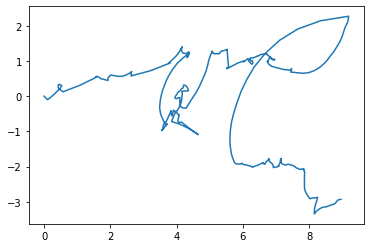

In [235]:
output_y = [-y for y in output_y]
plt.plot(output_x, output_y)

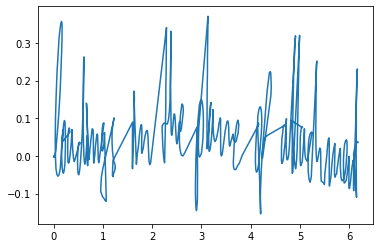

In [132]:
# just to make sure we're parsing data correctly, plot some of it
seq = seq_list[10]
xs = [0]
ys = [0]
for element in seq:
    xs.append(xs[-1] + element[0])
    ys.append(ys[-1] - element[1])
plt.plot(xs, ys)
plt.show()

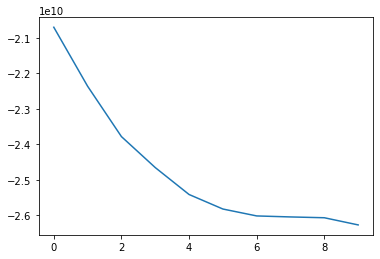

In [217]:
plt.plot(losses)
plt.show()